# 네이버 영화리뷰 감성분석
1. 데이터 준비 및 확인
2. 데이터 로더 구성
    - 데이터의 중복 제거
    - 한글 이외 특수문자 제거
    - NaN 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(Stopwords) 제거
    - 사전word_to_index 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환
    - X_train, y_train, X_test, y_test, word_to_index 리턴
3. 데이터 분포 분석 및 패딩
    - 전체 데이터셋 분포 확인하여 maxlen 결정
    - padding
4. 모델 설계, 훈련, 평가
    - LSTM
    - 1-D CNN
    - GlobalMaxPooling1D() 단일 레이어
5. 학습된 Embedding 레이어 분석
6. 한국어 Word2Vec 임베딩 활용하여 성능 개선
    - gensim의 유사단어 찾기를 활용하여 자체학습된 임베딩과 사전학습된 임베딩 비교

## 1. 데이터 준비 및 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 파일 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

print("train data 개수: {}, test data 개수: {}".format(len(train_data), len(test_data)))  # 데이터 개수 확인
train_data.head()  # 데이터 출력

train data 개수: 150000, test data 개수: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터 로더 구성

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어

# 데이터 로더 함수 정의
def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 특수문자 제거
    train_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 변경
    train_data = train_data.dropna(how = 'any')  # 결측치 제거
    # test data 전처리
    test_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 특수문자 제거
    test_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 변경
    test_data = test_data.dropna(how = 'any')  # 결측치 제거

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어사전 만들기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)  # 단어 빈도순으로 (10000-4)개 가져오기
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # 앞부분 4개 추가
    word_to_index = {word:index for index, word in enumerate(vocab)}  # {단어:인덱스} 단어사전 생성
    
    # 리뷰 텍스트를 단어사전 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 데이터 로더 실행하여 데이터셋 생성
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test)))

index_to_word = {index:word for word, index in word_to_index.items()}  # {인덱스:단어} 딕셔너리 생성

train data 개수: 145791, test data 개수: 48995


In [3]:
# 인코딩 & 디코딩 함수 정의
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# decode된 문장과 라벨을 비교하여 일치하는지 확인
for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[27, 67, 895, 33, 214, 15, 28, 699]
더 빙 진짜 짜증 나 네요 목소리
라벨:  0
[977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
라벨:  1
[19, 192, 2]
재 <UNK>
라벨:  0
[8035, 143, 4134, 277, 85, 13, 5, 52, 3326]
이야기 구먼 솔직히 재미 없 다 평점 조정
라벨:  0
[2, 8488, 1051, 48, 2702, 54, 4, 2625, 34, 1118, 29, 326, 36, 17, 35, 54, 2, 2, 393, 2850, 1677, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  1
[627, 2, 2, 425, 171, 1464, 661, 1592, 665, 46, 2, 4, 61, 2167, 118, 718]
<UNK> <UNK> 세 부터 초등 학교 학년 생 인 <UNK> 영화 ㅋㅋㅋ 별반 개 아까움
라벨:  0
[237, 351, 8, 354, 1909, 51, 11, 780, 5]
긴장감 을 제대로 살려 내 지 못했 다
라벨:  0
[232, 1344, 132, 5, 392, 705, 2, 2, 48, 1434, 269, 93, 233, 23, 882, 24, 321, 608, 501, 475, 546, 5, 3165, 8489, 17, 1386, 1386, 65, 282, 13, 5, 48, 95, 7, 70, 17, 2, 37]
반개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 정말 발 로 해도 그것 보단 낫 겟 다 납치 감금 만 반복 반복 드라마 가족 없 다 연기 못 하 사람 만 <UNK> 네
라벨:  0
[117, 13, 18, 85, 12, 269, 22, 43, 4]
없 는데 재미 있 몇 안 되 영화
라벨:  1
[57, 612

## 3. 데이터 분포 분석 및 패딩

In [4]:
# 텍스트 데이터 문장 길이의 리스트 생성
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장 길이의 평균, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 계산
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

문장길이 평균 :  13.757179674103888
문장길이 최대 :  83
문장길이 표준편차 :  11.462771769216866
pad_sequences maxlen :  36
전체 문장의 93.38145451931864%가 maxlen 설정값 이내에 포함됩니다. 


In [5]:
# padding으로 문장 길이 맞추기
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

print(X_train.shape)

(145791, 36)


In [6]:
# 훈련용 데이터셋 145791건 중 40000건을 분리하여 validation set으로 사용
x_val = X_train[:40000]
y_val = y_train[:40000]

# validation set을 제외한 나머지는 train set으로 사용
partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(105791, 36)
(105791,)


## 4. 모델 설계, 훈련, 평가

### 4-1. LSTM
Recurrent Neural Netowrk(RNN)은 텍스트 데이터를 다루는데 주로 사용되는 딥러닝 모델이다. RNN은 시퀀스(Sequence) 형태의 데이터 처리에 최적인 모델로, 이전 시점의 모든 입력의 정보가 현재 상태에 반영되는 state machine으로 설계되었다. LSTM은 RNN 중에서도 가장 널리 쓰이는 모델이다.

In [7]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [8]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 2s 8ms/step - loss: 0.6194 - accuracy: 0.6295 - val_loss: 0.4260 - val_accuracy: 0.8176
Epoch 2/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3779 - accuracy: 0.8394 - val_loss: 0.3661 - val_accuracy: 0.8404
Epoch 3/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3379 - accuracy: 0.8559 - val_loss: 0.3719 - val_accuracy: 0.8387
Epoch 4/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3224 - accuracy: 0.8616 - val_loss: 0.3720 - val_accuracy: 0.8375
Epoch 5/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3131 - accuracy: 0.8662 - val_loss: 0.3700 - val_accuracy: 0.8386


In [9]:
# test set으로 model 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.3760 - accuracy: 0.8343
[0.3760218024253845, 0.8343096375465393]


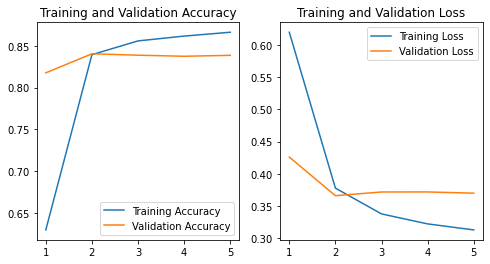

In [10]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4-2. 1-D CNN
텍스트 처리에 1-D Convolutional Neural Network(1-D CNN)을 사용할 수도 있다. 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 필터로 스캐닝하면서 필터 크기만큼의 단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식이다.

In [11]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [12]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 8s 41ms/step - loss: 0.5052 - accuracy: 0.7631 - val_loss: 0.3683 - val_accuracy: 0.8364
Epoch 2/5
207/207 [==============================] - 1s 4ms/step - loss: 0.3413 - accuracy: 0.8526 - val_loss: 0.3548 - val_accuracy: 0.8442
Epoch 3/5
207/207 [==============================] - 1s 4ms/step - loss: 0.3038 - accuracy: 0.8728 - val_loss: 0.3592 - val_accuracy: 0.8433
Epoch 4/5
207/207 [==============================] - 1s 4ms/step - loss: 0.2768 - accuracy: 0.8870 - val_loss: 0.3660 - val_accuracy: 0.8435
Epoch 5/5
207/207 [==============================] - 1s 5ms/step - loss: 0.2502 - accuracy: 0.8996 - val_loss: 0.3804 - val_accuracy: 0.8410


In [13]:
# test set으로 model 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 4s - loss: 0.3874 - accuracy: 0.8376
[0.3874152600765228, 0.8375752568244934]


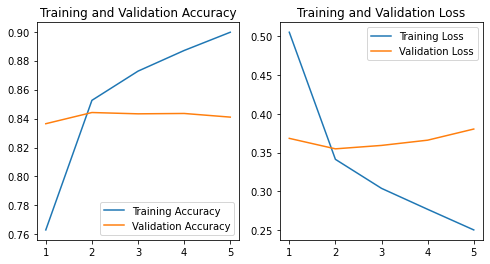

In [14]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4-3. GlobalMaxPooling1D
GlobalMaxPooling1D() 레이어 하나만 사용하는 방법은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이다.

In [15]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [16]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 1s 4ms/step - loss: 0.6424 - accuracy: 0.7207 - val_loss: 0.5457 - val_accuracy: 0.7981
Epoch 2/5
207/207 [==============================] - 1s 4ms/step - loss: 0.4435 - accuracy: 0.8248 - val_loss: 0.3880 - val_accuracy: 0.8289
Epoch 3/5
207/207 [==============================] - 1s 4ms/step - loss: 0.3537 - accuracy: 0.8506 - val_loss: 0.3685 - val_accuracy: 0.8354
Epoch 4/5
207/207 [==============================] - 1s 4ms/step - loss: 0.3220 - accuracy: 0.8650 - val_loss: 0.3648 - val_accuracy: 0.8376
Epoch 5/5
207/207 [==============================] - 1s 4ms/step - loss: 0.3000 - accuracy: 0.8763 - val_loss: 0.3671 - val_accuracy: 0.8391


In [17]:
# test set으로 model 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.3751 - accuracy: 0.8372
[0.3750719130039215, 0.8372078537940979]


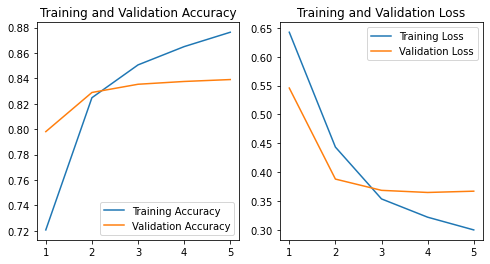

In [18]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5. 학습된 Embedding 레이어 분석

In [19]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [20]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("재미")  # 학습이 잘 되지 않아 별로 유사하지 않음

[('소시', 0.9774879217147827),
 ('한테', 0.9452472925186157),
 ('스팅', 0.9421142339706421),
 ('느껴집니다', 0.9361815452575684),
 ('너무', 0.9318095445632935),
 ('마저', 0.9273059368133545),
 ('조쉬하트넷', 0.924290120601654),
 ('조지', 0.9234365224838257),
 ('빨리', 0.9200395345687866),
 ('어유', 0.9155139327049255)]

## 6. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [22]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector.shape     # 200dim의 워드 벡터

/home/ssac21/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(200,)

In [23]:
# 유사한 단어와 그 유사도 확인
word2vec.wv.most_similar("재미")  # 학습이 잘 되어 유사함

[('취미', 0.5857348442077637),
 ('유머', 0.514061450958252),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338053226471),
 ('공짜', 0.4960595965385437),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700761795043945),
 ('비애', 0.4836210608482361),
 ('관객', 0.4828645586967468),
 ('향수', 0.48233112692832947)]

In [24]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000     # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/ssac21/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/ssac21/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [25]:
# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1653/1653 [==============================] - 27s 17ms/step - loss: 0.4390 - accuracy: 0.7831 - val_loss: 0.3439 - val_accuracy: 0.8482
Epoch 2/5
1653/1653 [==============================] - 28s 17ms/step - loss: 0.3087 - accuracy: 0.8677 - val_loss: 0.3295 - val_accuracy: 0.8553
Epoch 3/5
1653/1653 [==============================] - 27s 16ms/step - loss: 0.2637 - accuracy: 0.8886 - val_loss: 0.3308 - val_accuracy: 0.8565
Epoch 4/5
1653/1653 [==============================] - 26s 16ms/step - loss: 0.2238 - accuracy: 0.9080 - val_loss: 0.3534 - val_accuracy: 0.8558
Epoch 5/5
1653/1653 [==============================] - 27s 16ms/step - loss: 0.1849 - accuracy: 0.9262 - val_loss: 0.3653 - val_accuracy: 0.8540


In [27]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)   # 정확도가 0.85으로 개선됨

1532/1532 - 3s - loss: 0.3687 - accuracy: 0.8510
[0.36866456270217896, 0.8510256409645081]


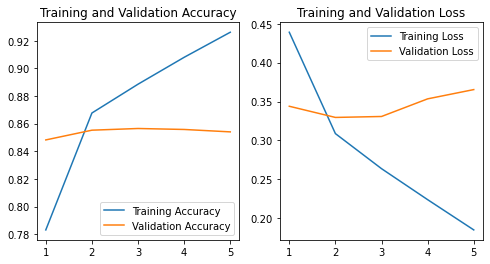

In [28]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 프로젝트 정리
- LSTM, 1-D CNN, GlobalMaxPooling1D 단일 레이어까지 총 3가지 모델로 학습을 시켜보았다. 정확도는 모두 83% 수준으로 유의미한 차이가 없었다. 다만 epoch을 거듭할수록 training loss는 감소하지만 validation loss는 증가하여 둘 사이에 격차가 벌어지는 경향이 있었다. epochs를 10에서 5로 줄였더니 격차가 줄어들었다.
- gensim의 유사단어 찾기를 통해 자체학습한 임베딩과 사전학습된 임베딩을 비교해보았다. '재미'라는 단어로 비교했을 때, 자체학습한 임베딩은 재미와 관련 없는 단어들이 나와서 제대로 학습되지 않은 것을 알 수 있었고, word2vec은 '유머', '흥미', '즐거움' 등 유사도가 높은 단어가 나와 사전학습이 잘 이루어진 것을 확인할 수 있었다.
- 사전학습된 word2vec을 사용하면 모델의 성능이 많이 개선될 것이라 기대했지만, 실제로는 정확도가 85%로 조금밖에 향상되지 않았다. 모델 구성이나 하이퍼파라미터 값을 바꿔봐도 85% 이상을 넘기기가 어려웠다. 한국어의 구조가 복잡하고 형태소 분석까지 추가되기 때문에 word2vec을 사용해도 영어 텍스트에 비해 눈에 띄는 효과가 없는 것 같다. 그리고 네이버 영화리뷰 데이터 자체에 잘못된 라벨이나 노이즈가 포함되어 있을 가능성도 있는 것 같다.